In [1]:
%matplotlib inline

# Bokeh for interactive, Seaborn for static

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set(style="whitegrid", palette="pastel")
# sns.set(style="whitegrid", palette=sns.color_palette("RdBu", n_colors=2))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from math import pi
import glob

In [2]:
def m_to_cm(x):
    return x * 100
def unit(x):
    return x
def scale_to_rads(x):
    return 20 * x

fsm_map = [
    {'name': 'Wheel Base'        , 'default': 0.08, 'minval': 0.08, 'maxval': 0.16, 'T': m_to_cm},
    {'name': 'Track Width'       , 'default': 0.12, 'minval': 0.08, 'maxval': 0.16, 'T': m_to_cm},
    {'name': 'Wheel Radius'      , 'default': 0.02, 'minval': 0.02, 'maxval': 0.03, 'T': m_to_cm},
    {'name': 'Weg Count'         , 'default': 3   , 'minval': 0   , 'maxval': 7.99, 'T': int  },
    {'name': 'Ext. Slope'        , 'default': 0.5 , 'minval': 0   , 'maxval': 1   , 'T': unit},
    {'name': 'Ext. Intercept'    , 'default': 0.5 , 'minval': 0   , 'maxval': 1   , 'T': unit},
    {'name': 'F. Speed'          , 'default': 1   , 'minval': 0   , 'maxval': 1   , 'T': scale_to_rads},
    {'name': 'F. Left Thresh'    , 'default': 0.17, 'minval': 0   , 'maxval': pi/2, 'T': np.rad2deg},
    {'name': 'F. Right Thresh'   , 'default':-0.17, 'minval':-pi/2, 'maxval': 0   , 'T': np.rad2deg},
    {'name': 'L. Speed Left'     , 'default':-1   , 'minval':-1   , 'maxval': 1   , 'T': scale_to_rads},
    {'name': 'L. Speed Right'    , 'default': 1   , 'minval':-1   , 'maxval': 1   , 'T': scale_to_rads},
    {'name': 'L. Forward Thresh' , 'default': 0.08, 'minval': 0   , 'maxval': pi/2, 'T': np.rad2deg},
    {'name': 'R. Speed Left'     , 'default': 1   , 'minval':-1   , 'maxval': 1   , 'T': scale_to_rads},
    {'name': 'R. Speed Right'    , 'default':-1   , 'minval':-1   , 'maxval': 1   , 'T': scale_to_rads},
    {'name': 'R. Forward Thresh' , 'default':-0.08, 'minval':-pi/2, 'maxval': 0   , 'T': np.rad2deg},
]
fsm_fancy_names = [
    r'WheelBase (cm)',r'TrackWidth (cm)',r'WheelRadius (cm)',r'StrutCount',r'$m_{ext}$ ($\%$)',
    r'$b_{ext}$ ($\%$)',r'F.Speed (rad $s^{-1}$)',r'F.ToLeftThresh ($^\circ$)',
    r'F.ToRightThresh ($^\circ$)',r'L.LeftSpeed (rad $s^{-1}$)',r'L.RightSpeed (rad $s^{-1}$)',
    r'L.ToForwardThresh ($^\circ$)',r'R.LeftSpeed (rad $s^{-1}$)',r'R.RightSpeed (rad $s^{-1}$)',
    r'R.ToForwardThresh ($^\circ$)'
]
for m, n in zip(fsm_map, fsm_fancy_names):
    m['fancy_name'] = n


bnn_map = [
    {'name': 'Wheel Base'        , 'default': 0.08, 'minval': 0.08, 'maxval': 0.16, 'T': m_to_cm},
    {'name': 'Track Width'       , 'default': 0.12, 'minval': 0.08, 'maxval': 0.16, 'T': m_to_cm},
    {'name': 'Wheel Radius'      , 'default': 0.02, 'minval': 0.02, 'maxval': 0.03, 'T': m_to_cm},
    {'name': 'Weg Count'         , 'default': 3   , 'minval': 0   , 'maxval': 7.99, 'T': int  },
    {'name': 'Act. Func.'        , 'default': 0   , 'minval': 0   , 'maxval': 2.99, 'T': int  },
]
bnn_map.extend([{
    'name': 'weight{}'.format(i), 
    'default': 0, 
    'minval': -4, 
    'maxval': 4, 
    'T': float} for i in range(12)])
bnn_fancy_names = [r'WheelBase (cm)',r'TrackWidth (cm)',r'WheelRadius (cm)',r'StrutCount',r'Act.Func.']
bnn_fancy_names += ['Weight {}'.format(widx) for widx in range(12)]
for m, n in zip(bnn_map, bnn_fancy_names):
    m['fancy_name'] = n


cmaes_header = ['iter', 'evals', 'sigma', '0', 'fitness']
fsm_header = cmaes_header + [arg['name'] for arg in fsm_map]
bnn_header = cmaes_header + [arg['name'] for arg in bnn_map]


def range_transform(x, a, b, c, d):
    return (x - a) * (d - c) / (b - a) + c

In [4]:
num_obst = 0

if num_obst == 0:
    fsm_param_files = '../experiments/fsm-0-1/seed*/outcmaesxrecentbest.dat'
    bnn_param_files = '../experiments/bnn-0-1/seed*/outcmaesxrecentbest.dat'
    tws_param_files = '../experiments/bnn_twist-0-1/seed*/outcmaesxrecentbest.dat'
else:
    fsm_param_files = '../experiments/fsm-40-2/seed*/outcmaesxrecentbest.dat'
    bnn_param_files = '../experiments/bnn-40-2/seed*/outcmaesxrecentbest.dat'
    tws_param_files = '../experiments/bnn_twist-40-2/seed*/outcmaesxrecentbest.dat'

# fsm_param_files = '../experiments/fsm-30-2/seed*/outcmaesxrecentbest.dat'
# bnn_param_files = '../experiments/bnn-30-2/seed*/outcmaesxrecentbest.dat'


def get_data_from_file(glob_dir, header, param_map):
    data = []
    for pop_filepath in sorted(glob.iglob(glob_dir, recursive=True)):
        data.append(pd.read_csv(pop_filepath, comment='%', header=None, names=header, sep=' '))
        data[-1]['fitness'] = (data[-1]['fitness'] * -1) + 1
        for m in param_map:
            data[-1][m['name']] = data[-1][m['name']].apply(
                lambda x: m['T'](range_transform(x, 0, 10, m['minval'], m['maxval'])))
    return data


fsm_replicates = get_data_from_file(fsm_param_files, fsm_header, fsm_map)
print('Found', len(fsm_replicates), 'data files in', fsm_param_files)

bnn_replicates = get_data_from_file(bnn_param_files, bnn_header, bnn_map)
print('Found', len(bnn_replicates), 'data files in', bnn_param_files)

tws_replicates = get_data_from_file(tws_param_files, bnn_header, bnn_map)
print('Found', len(tws_replicates), 'data files in', tws_param_files)

Found 20 data files in ../experiments/fsm-0-1/seed*/outcmaesxrecentbest.dat
Found 20 data files in ../experiments/bnn-0-1/seed*/outcmaesxrecentbest.dat
Found 20 data files in ../experiments/bnn_twist-0-1/seed*/outcmaesxrecentbest.dat


In [5]:
fsm_replicates_combined = pd.concat(fsm_replicates).reset_index(drop=True)
bnn_replicates_combined = pd.concat(bnn_replicates).reset_index(drop=True)
tws_replicates_combined = pd.concat(tws_replicates).reset_index(drop=True)

In [6]:
df_fsm_best = fsm_replicates_combined.nlargest(240, 'fitness').copy()
df_bnn_best = bnn_replicates_combined.nlargest(240, 'fitness').copy()
df_tws_best = tws_replicates_combined.nlargest(240, 'fitness').copy()

/Users/ajc/miniconda3/envs/analyze/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


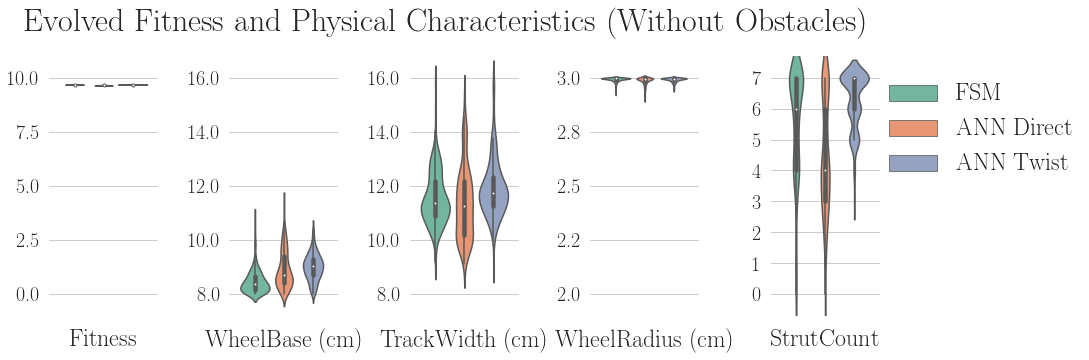

In [7]:
# Physical Characteristics

ticksize = 20
labelsize = 24
legendsize = labelsize
titlesize = 32

col_names = ['fitness', 'Wheel Base', 'Track Width', 'Wheel Radius', 'Weg Count']

df_fsm_phys = df_fsm_best[col_names].copy()
df_bnn_phys = df_bnn_best[col_names].copy()
df_tws_phys = df_tws_best[col_names].copy()

df_fsm_phys['Category'] = 'FSM'
df_bnn_phys['Category'] = 'ANN Direct'
df_tws_phys['Category'] = 'ANN Twist'

df = pd.concat([df_fsm_phys, df_bnn_phys, df_tws_phys], keys=['FSM', 'ANN1', 'ANN2'], axis=0)
df['all'] = ''


col_offset = 5
col_count = 4
col_names = df_fsm_best.columns[col_offset:col_offset + col_count]
ncols = len(col_names) + 1
fsize = ncols * 2.5, 9/2
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=fsize)

colors = sns.color_palette(['#1b9e77','#d95f02','#7570b3'])
if num_obst == 0:
    colors = sns.color_palette(['#66c2a5','#fc8d62','#8da0cb'])

for ax, col_name, map_idx in zip(axes, ['fitness'] + list(col_names), range(-1, ncols)):

    if map_idx == -1:
        ymin, ymax = 0, 10
        fancy_name = 'Fitness'
    else:
        m = fsm_map[map_idx]
        ymin, ymax = m['T'](m['minval']), m['T'](m['maxval'])
        fancy_name = m['fancy_name']
    
    # Plot the violin for this parameter
    sns.violinplot(x='all'
                   , y=col_name
                   , data=df
                   , hue='Category'
                   , ax=ax
                   , palette=colors
#                    , inner=None
#                    , split=True
#                    , scale_hue=False
#                    , scale='width'
                  )

    # Set the y limits with some padding
    y_padding = (ymax - ymin) * 0.1
    ylims_with_padding = [ymin - y_padding, ymax + y_padding]
    ax.set_ylim(ylims_with_padding)
    
    # Prettify the lines and ticks
    if col_name == 'Weg Count':
        yticks = np.linspace(ymin, ymax, num=ymax + 1)
        ax.set_yticklabels([int(yval) for yval in yticks], fontsize=ticksize)
    else:
        yticks = np.linspace(ymin, ymax, num=5)
        ax.set_yticklabels([round(yval, 1) for yval in yticks], fontsize=ticksize)
    ax.set_yticks(yticks)

    ax.set_xlabel(fancy_name, fontsize=labelsize)
    ax.set_ylabel('')
    
    ax.legend_.remove()
#     ax.plot([0, 0], ylims_with_padding, color='0.3', linestyle='-', linewidth=3)
    
sns.despine(top=True, right=True, left=True, bottom=True)
plt.tight_layout()

lgd = axes[-1].legend(loc=(1,0.5), fontsize=legendsize, frameon=False)


title = 'Evolved Fitness and Physical Characteristics (With Obstacles)'
if num_obst == 0:
    title = 'Evolved Fitness and Physical Characteristics (Without Obstacles)'
ttl = fig.suptitle(title, fontsize=titlesize, y=1.1)

# fig.savefig('morph-params.png')
# handles, labels = axes[-1].get_legend_handles_labels()
# lgd = axes[-1].legend(handles, labels, loc=(1, 0.5), fontsize=16)#, bbox_to_anchor=(0.5,-0.1))

# fig.savefig('params1.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
# fig.savefig('params2.png', bbox_extra_artists=(lgd,), bbox_inches='tight')


In [31]:
fig_filename = '40-2-best_params.png'
if num_obst == 0:
    fig_filename = '0-1-best_params.png'

fig.savefig(fig_filename, bbox_extra_artists=(lgd, ttl), bbox_inches='tight')

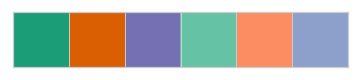

In [8]:
sns.palplot(sns.color_palette(['#1b9e77','#d95f02','#7570b3','#66c2a5','#fc8d62','#8da0cb']))

In [9]:
def plot_violins(df, col_names, map_offset, violin_size, exp_map, color):
    col_count = len(col_names)
    df_violin = df[col_names].copy()
    
    figsize = violin_size[0] * col_count, violin_size[1]

    fig, axes = plt.subplots(nrows=1, ncols=col_count, figsize=figsize)

    for ax, col_name, map_idx in zip(axes, col_names, range(map_offset, map_offset + col_count)):
        m = exp_map[map_idx]
        ymin, ymax = m['T'](m['minval']), m['T'](m['maxval'])

        # Plot the violin for this parameter
        sns.violinplot(df_violin[col_name], ax=ax, orient='v', palette=color)

        # Set the y limits with some padding
        y_padding = (ymax - ymin) * 0.1
        ylims_with_padding = [ymin - y_padding, ymax + y_padding]
        ax.set_ylim(ylims_with_padding)

        # Prettify the lines and ticks
        yticks = np.linspace(ymin, ymax, num=5)
        ax.set_yticks(yticks)
        ax.set_yticklabels([round(yval, 1) for yval in yticks], fontsize=ticksize)
        ax.set_xlabel(m['fancy_name'], fontsize=18)
        ax.set_ylabel('')

    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.tight_layout()
    return fig, axes

/Users/ajc/miniconda3/envs/analyze/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


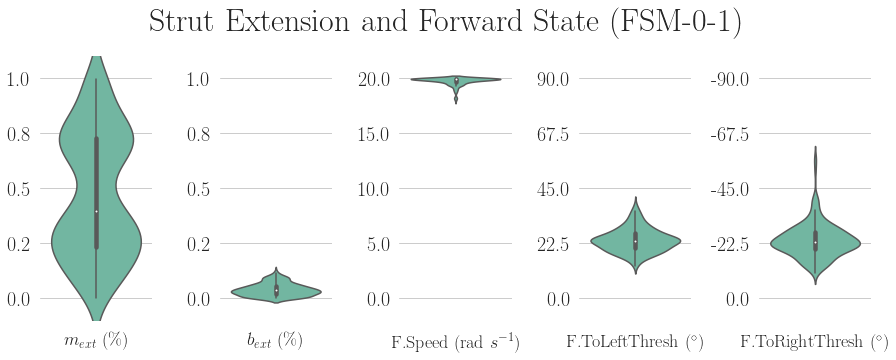

In [10]:
col_start = 9
col_count = 5
figsize = (2.5, 4.5)
col_names = list(df_fsm_best.columns[col_start:col_start + col_count])
fig, axes = plot_violins(df_fsm_best, col_names, col_start - 5, figsize, fsm_map, color=colors)
axes[4].invert_yaxis()
# axes[10].invert_yaxis()

exp_ttle = ' (FSM-0-1)' if num_obst == 0 else ' (FSM-40-2)'
ttl = fig.suptitle('Strut Extension and Forward State' + exp_ttle, fontsize=titlesize, y=1.1)

In [11]:
figfilename = 'FSM'
figfilename += '-0-1' if num_obst == 0 else '-40-2'
figfilename += '-strut-forward.pdf'
fig.savefig(figfilename, bbox_extra_artists=(ttl,), bbox_inches='tight')

/Users/ajc/miniconda3/envs/analyze/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


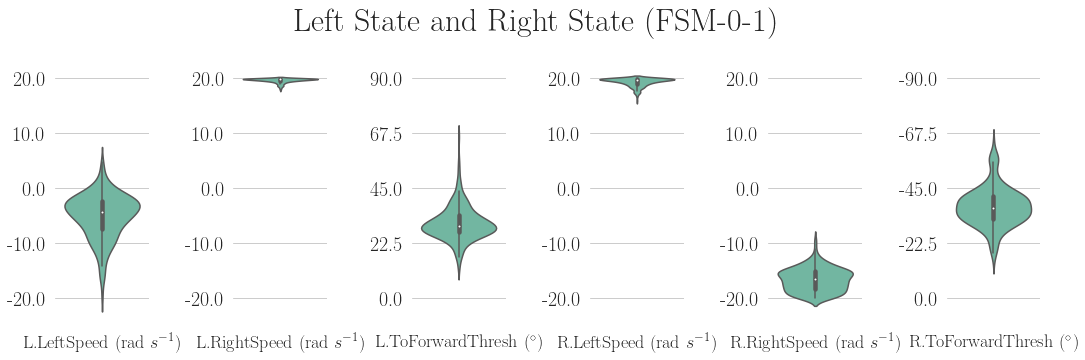

In [12]:
col_start = 14
col_count = 6
col_names = list(df_fsm_best.columns[col_start:col_start + col_count])
fig, axes = plot_violins(df_fsm_best, col_names, col_start - 5, figsize, fsm_map, colors)
axes[5].invert_yaxis()

exp_ttle = ' (FSM-0-1)' if num_obst == 0 else ' (FSM-40-2)'
ttl = fig.suptitle('Left State and Right State' + exp_ttle, fontsize=titlesize, y=1.1)

In [13]:
figfilename = 'FSM'
figfilename += '-0-1' if num_obst == 0 else '-40-2'
figfilename += '-left-right.pdf'
fig.savefig(figfilename, bbox_extra_artists=(ttl,), bbox_inches='tight')

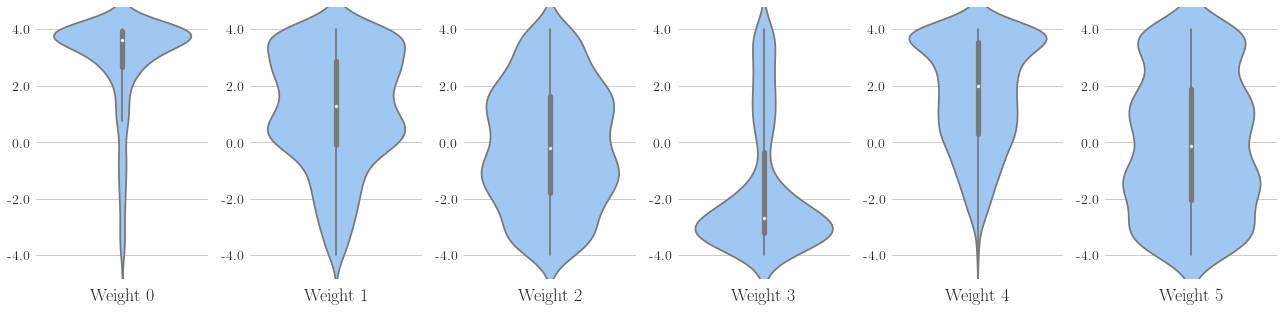

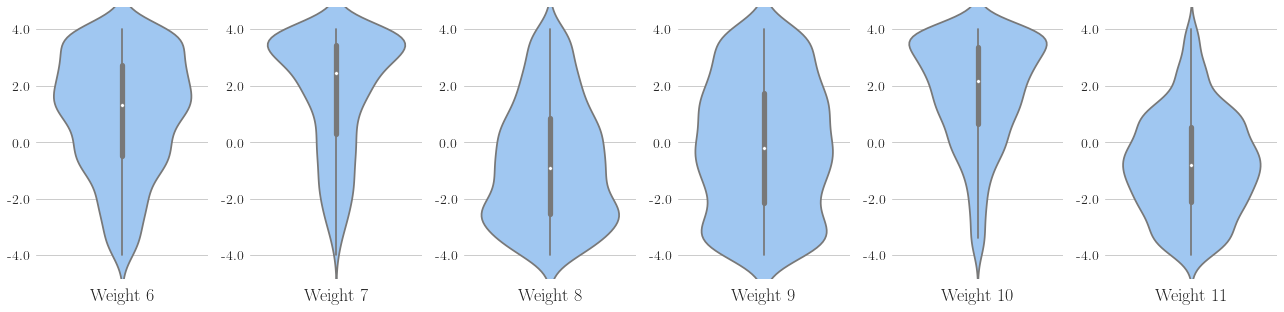

In [179]:
col_start = 10
col_count = 6
col_names = list(df_bnn_best.columns[col_start:col_start + col_count])
fig1, axes1 = plot_violins(df_bnn_best, col_names, col_start - 5, figsize, bnn_map)

col_start = 16
col_count = 6
col_names = list(df_bnn_best.columns[col_start:col_start + col_count])
fig2, axes2 = plot_violins(df_bnn_best, col_names, col_start - 5, figsize, bnn_map)

In [186]:
df_fsm_best.describe()

,iter,evals,sigma,0,fitness,Wheel Base,Track Width,Wheel Radius,Weg Count,Ext. Slope,Ext. Intercept,F. Speed,F. Left Thresh,F. Right Thresh,L. Speed Left,L. Speed Right,L. Forward Thresh,R. Speed Left,R. Speed Right,R. Forward Thresh
count,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,671.000000,8052.000000,0.572895,0.0,9.684896,8.505860,11.699521,2.991852,5.80300,0.450636,4.382033e-02,19.754327,24.515723,-22.901724,-5.551051,19.557879,30.996168,19.262425,-16.708977,-37.199910
std,370.440535,4445.286424,0.267139,0.0,0.004289,0.483091,0.997987,0.012402,1.63489,0.283770,2.830392e-02,0.341616,5.208532,7.556786,4.409964,0.589735,7.387441,0.949659,2.255503,8.557191
min,51.000000,612.000000,0.245233,0.0,9.680000,8.000001,9.186405,2.853960,0.00000,0.001009,2.871581e-07,17.783572,9.164130,-60.380699,-19.702714,15.526238,10.723601,14.000887,-19.998342,-63.882178
25%,391.000000,4692.000000,0.390138,0.0,9.683333,8.158177,11.012356,2.989354,5.00000,0.211666,2.272095e-02,19.640432,20.851445,-26.250941,-7.953091,19.392290,26.847067,18.969936,-18.699736,-41.827477
50%,593.500000,7122.000000,0.512162,0.0,9.683333,8.386722,11.493924,2.996893,7.00000,0.393661,4.044124e-02,19.905355,23.969891,-21.685337,-4.674477,19.765466,30.247484,19.622474,-16.780106,-36.746445
75%,924.750000,11097.000000,0.664819,0.0,9.686667,8.711754,12.372771,2.999364,7.00000,0.699851,6.262078e-02,19.981818,27.915606,-17.942789,-2.539973,19.949020,34.297217,19.920903,-15.138492,-31.696168
max,1586.000000,19032.000000,1.928199,0.0,9.706500,11.279621,15.876401,3.000000,7.00000,0.999976,2.201794e-01,19.999999,41.010230,-6.835558,4.818010,19.999995,66.182999,19.999997,-3.931527,-12.537482
